In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn import metrics
from datetime import datetime
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import model_to_dot
from keras.utils import plot_model
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from statistics import variance
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import cv
from sklearn.metrics import make_scorer

In [2]:
dataset=pd.read_csv("dataset.csv")

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (56,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
dataset=dataset.replace({"--":np.nan})
#dataset.describe()

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39961 entries, 0 to 39960
Data columns (total 71 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Sample                    39961 non-null  int64  
 1   ID                        39961 non-null  int64  
 2   DATA                      39961 non-null  int64  
 3   LONGITUDE                 39961 non-null  int64  
 4   LATITUDE                  39961 non-null  int64  
 5   City                      39961 non-null  object 
 6   Postal Code               39955 non-null  object 
 7   Community                 39961 non-null  object 
 8   Property Type             39961 non-null  object 
 9   Building Style            39913 non-null  object 
 10  Bedrooms AG               39888 non-null  float64
 11  Bedrooms BG               18701 non-null  float64
 12  Washrooms                 39961 non-null  int64  
 13  Kitchen                   39887 non-null  float64
 14  Family

تاریخ به صورت متنی است تبدیل به دیتا تایپ تاریخ شده و سپس تبدیل به یک عدد اردینالی مرتب بر حسب ماه شده است

In [5]:
def convert_date(date):
    try:
        return  datetime.strptime(date,'%m/%d/%Y' )    
    except: 
        try:   
            return  datetime.strptime(date, '%d/%m/%Y')
        except:
            #print(date)
            return np.nan
    

def convert_month(date):
    return (date.year-2016)*12+(date.month-1)

dataset['Sold Date']=[convert_date(X) for X in dataset['Sold Date'].tolist()]
dataset['Date']=[convert_month(X) for X in dataset['Sold Date'].tolist()]

In [6]:
mortgage=pd.read_csv("book3.csv").dropna()
#mortgage["Date"]=[datetime.strptime(X,'%b-%y' ) for X in mortgage["Jul-110 *M Disaggregate_All"].tolist()]
#mortgage["Date"]=[convert_month(X) for X in mortgage["Date"].tolist()]
#mortgage=mortgage[mortgage["Date"]>=0]
#mortgage=mortgage[mortgage["Date"]<25]
#mortgage["MortgageRate"]=mortgage["V122520@CANADA"]
#mortgage=mortgage.drop(["Jul-110 *M Disaggregate_All","V122520@CANADA"],axis=1)
dataset["MortgageRate"]=[mortgage["V122520@CANADA"][d+66] for d in dataset["Date"].values]

عمینیتی های در اینجا به مانند سبد خرید در شش ستون مختلف امده است 
با کمک کتاب خانه تبدیل به 23 ستون یولی شده اند

In [7]:
amenities_list=dataset[['Amenities 1', 'Amenities 2', 'Amenities 3', 'Amenities 4', 'Amenities 5', 'Amenities 6']].fillna("None").values
#The TransactionEncoder returna  a "True" and "False" Matrix.
te = TransactionEncoder()
te_ary = te.fit(amenities_list).transform(amenities_list)
#convert all "bool" type to "int".
te_ary=te_ary.astype("int")
amenities_df=pd.DataFrame(te_ary, columns=te.columns_).drop("None",axis=1)
dataset[list(amenities_df.columns)]=amenities_df

In [8]:
temp_dataset=dataset[['ID','Postal Code','LONGITUDE', 'LATITUDE','Latitude:1', 'Longtitude','Expirey Date','Terminated Date','Suspended Date','Closing Date',"Community","neighbourhood_ID","Ward"]]


In [9]:
dataset=dataset.drop(['Sample', 'City','Status','Status Auto','Region','Transaction Type',"Kitchen"],axis=1) # low varience
dataset=dataset.drop(['DATA','Postal Code','LONGITUDE', 'LATITUDE','Latitude:1', 'Longtitude'],axis=1) #No info
dataset=dataset.drop(["Picture Exists",'Corp #','Management Company','green_date'],axis=1)
dataset=dataset.drop(['Expirey Date','Terminated Date','Suspended Date','Closing Date','Contract Date', 'Sold Date'],axis=1)
dataset=dataset.drop(["Community","neighbourhood_ID","neighbourhood_name"],axis=1) #equal to neighbourhood_name  
dataset=dataset.drop(["Age Range","Locker Unit","Parking Spot"],axis=1) # miss value
dataset=dataset.drop(['Amenities 1', 'Amenities 2', 'Amenities 3', 'Amenities 4', 'Amenities 5', 'Amenities 6'],axis=1) # converted

In [10]:
dataset['Bedrooms BG']=dataset['Bedrooms BG'].fillna(0) #fill miss value with zero
dataset['Bedrooms AG']=dataset['Bedrooms AG'].fillna(-1) #fill miss value with -1
dataset['Family Room']=dataset['Family Room'].fillna(0) #fill miss value with zero
dataset['Basement']=dataset['Basement'].fillna("None") #fill miss value with "None": dont have any basement
dataset["Heat Source"]=dataset["Heat Source"].fillna("Other") #fill miss value with "Other"

In [11]:
# problem in .csv file string instead of num
# convert sring to int

In [12]:
def convert_toInt(num):
    try:
        return int(float(num))
    except:
        return np.nan  
    
dataset["Sale to List %"]=[convert_toInt(X) for X in dataset["Sale to List %"].tolist()]
dataset['Maint. Fees']=[convert_toInt(X) for X in dataset['Maint. Fees'].tolist()]
dataset['Total Rooms']=[convert_toInt(X) for X in dataset['Total Rooms'].tolist()]
dataset['Family Room']=[convert_toInt(X) for X in dataset['Family Room'].tolist()]
dataset['Common Elements Included']=[convert_toInt(X) for X in dataset['Common Elements Included'].tolist()]
dataset['Taxes Included']=[convert_toInt(X) for X in dataset['Taxes Included'].tolist()]
dataset['Heat included']=[convert_toInt(X) for X in dataset['Heat included'].tolist()]
dataset['Water Included']=[convert_toInt(X) for X in dataset['Water Included'].tolist()]
dataset['Hydro Included']=[convert_toInt(X) for X in dataset['Hydro Included'].tolist()]
dataset['Parking Included']=[convert_toInt(X) for X in dataset['Parking Included'].tolist()]
dataset['Ensuite Laundry']=[convert_toInt(X) for X in dataset['Ensuite Laundry'].tolist()]

In [13]:
print('Ownership Type:')
print("Condo:",set(dataset[dataset['Ownership Type']=='Condo']['Property Type']))
print("Free:",set(dataset[dataset['Ownership Type']=='Free']['Property Type']))

Ownership Type:
Condo: {'Co-Ownership Apt', 'Condo Townhouse', 'Other', 'Parking Space', 'Semi-Det Condo', 'Condo Apt', 'Comm Element Condo', 'Co-Op Apt', 'Leasehold Condo', 'Locker', 'Det Condo'}
Free: {'Fourplex', 'Other', 'Duplex', 'Detached', 'Vacant Land', 'Triplex', 'Multiplex', 'Link', 'Det W/Com Elements', 'Att/Row/Twnhouse', 'Store W/Apt/Offc', 'Semi-Detached'}


In [14]:
dataset.columns

Index(['ID', 'Property Type', 'Building Style', 'Bedrooms AG', 'Bedrooms BG',
       'Washrooms', 'Family Room', 'Basement', 'Exposure', 'Square Feet',
       'Parking Type', 'Taxes', 'Maint. Fees', 'AC Type', 'Heat Type',
       'Common Elements Included', 'Taxes Included', 'Heat included',
       'Water Included', 'Hydro Included', 'Parking Included',
       'Ensuite Laundry', 'Locker', 'Balcony', 'List Price', 'Sold Price',
       'Days on Market', 'Pets Permitted', 'Original Price', 'Heat Source',
       'Hold Over Days', 'Total Rooms', 'Ownership Type', 'Sale to List %',
       'Ward', 'green_new', 'Date', 'MortgageRate', 'Bbqs Allowed',
       'Bike Storage', 'Bus Ctr (Wifi Bldg)', 'Car Wash', 'Concierge',
       'Exercise Room', 'Games Room', 'Guest Suites', 'Gym', 'Indoor Pool',
       'Lap Pool', 'Media Room', 'Outdoor Pool', 'Party/Meeting Room',
       'Recreation Room', 'Rooftop Deck/Garden', 'Satellite Dish', 'Sauna',
       'Security Guard', 'Security System', 'Squash/Rac

In [15]:
Apt_Type=['Semi-Det Condo','Condo Apt','Leasehold Condo',"Co-Ownership Apt",'Co-Op Apt','Comm Element Condo','Det Condo','Condo Townhouse']

Apt_Attributes=['Property Type', 'Building Style','Bedrooms AG', 'Bedrooms BG',
       'Washrooms','Family Room','Exposure', 'Square Feet', 'Parking Type','Taxes',
       'Maint. Fees', 'AC Type', 'Heat Type', 'Common Elements Included',
       'Taxes Included', 'Heat included', 'Water Included', 'Hydro Included',
       'Parking Included', 'Ensuite Laundry', 'Locker', 'Balcony', 'Pets Permitted','Heat Source',
       'Total Rooms', 'Ward',
       'green_new', 'Bbqs Allowed', 'Bike Storage', 'Bus Ctr (Wifi Bldg)',
       'Car Wash', 'Concierge', 'Exercise Room', 'Games Room', 'Guest Suites',
       'Gym', 'Indoor Pool', 'Lap Pool', 'Media Room', 'Outdoor Pool',
       'Party/Meeting Room', 'Recreation Room', 'Rooftop Deck/Garden',
       'Satellite Dish', 'Sauna', 'Security Guard', 'Security System',
       'Squash/Racquet Court', 'Tennis Court', 'Visitor Parking','Date',"MortgageRate",'Sale to List %','Days on Market','Sold Price','List Price']

In [16]:
# Filter according to "Property Type", then their attributes.
Apt_dataset=dataset[dataset["Property Type"].isin(Apt_Type)]
Apt_dataset=Apt_dataset[Apt_Attributes]

In [17]:
is_NaN = Apt_dataset.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = Apt_dataset[row_has_NaN]
rows_with_NaN

,Property Type,Building Style,Bedrooms AG,Bedrooms BG,Washrooms,Family Room,Exposure,Square Feet,Parking Type,Taxes,...,Security System,Squash/Racquet Court,Tennis Court,Visitor Parking,Date,MortgageRate,Sale to List %,Days on Market,Sold Price,List Price
22387,Condo Townhouse,2-Storey,3.0,1.0,2,0,N,NaN,Attached,2178.47,...,0,0,0,1,22,3.24,100.0,25,550000,548000
34370,Condo Apt,Other,1.0,1.0,1,0,NaN,800-899,Other,2002.00,...,0,0,0,0,11,3.14,99.0,19,345000,349900
38031,Condo Apt,Other,1.0,1.0,1,0,NaN,600-699,Other,1575.00,...,0,0,0,0,7,3.14,99.0,212,266000,270000
38515,Condo Apt,Other,1.0,1.0,1,1,NaN,900-999,NaN,1164.00,...,0,0,0,0,4,3.14,100.0,10,250000,249900


In [18]:
# drop collom contine miss value

In [19]:
Apt_dataset=Apt_dataset.dropna() 

## Apt Dataset

In [20]:
print(Apt_dataset.columns)

Index(['Property Type', 'Building Style', 'Bedrooms AG', 'Bedrooms BG',
       'Washrooms', 'Family Room', 'Exposure', 'Square Feet', 'Parking Type',
       'Taxes', 'Maint. Fees', 'AC Type', 'Heat Type',
       'Common Elements Included', 'Taxes Included', 'Heat included',
       'Water Included', 'Hydro Included', 'Parking Included',
       'Ensuite Laundry', 'Locker', 'Balcony', 'Pets Permitted', 'Heat Source',
       'Total Rooms', 'Ward', 'green_new', 'Bbqs Allowed', 'Bike Storage',
       'Bus Ctr (Wifi Bldg)', 'Car Wash', 'Concierge', 'Exercise Room',
       'Games Room', 'Guest Suites', 'Gym', 'Indoor Pool', 'Lap Pool',
       'Media Room', 'Outdoor Pool', 'Party/Meeting Room', 'Recreation Room',
       'Rooftop Deck/Garden', 'Satellite Dish', 'Sauna', 'Security Guard',
       'Security System', 'Squash/Racquet Court', 'Tennis Court',
       'Visitor Parking', 'Date', 'MortgageRate', 'Sale to List %',
       'Days on Market', 'Sold Price', 'List Price'],
      dtype='object')


In [21]:
Apt_dataset['Property Type'].value_counts()

Condo Apt             20285
Condo Townhouse        2597
Comm Element Condo      513
Co-Op Apt                97
Co-Ownership Apt         58
Leasehold Condo           9
Det Condo                 8
Semi-Det Condo            4
Name: Property Type, dtype: int64

In [22]:
Apt_dataset['Property Type']=Apt_dataset['Property Type'].replace("Comm Element Condo","Other Property")
Apt_dataset['Property Type']=Apt_dataset['Property Type'].replace("Co-Op Apt","Other Property")
Apt_dataset['Property Type']=Apt_dataset['Property Type'].replace("Co-Ownership Apt","Other Property")
Apt_dataset['Property Type']=Apt_dataset['Property Type'].replace("Leasehold Condo","Other Property")
Apt_dataset['Property Type']=Apt_dataset['Property Type'].replace("Det Condo","Other Property")
Apt_dataset['Property Type']=Apt_dataset['Property Type'].replace("Semi-Det Condo","Other Property")
Apt_dataset['Property Type'].value_counts()

Condo Apt          20285
Condo Townhouse     2597
Other Property       689
Name: Property Type, dtype: int64

In [23]:
Apt_dataset['Condo Apt']=(Apt_dataset['Property Type']=='Condo Apt').astype(int)
Apt_dataset['Condo Townhouse']=(Apt_dataset['Property Type']=='Condo Townhouse').astype(int)
Apt_dataset['Other Property']=(Apt_dataset['Property Type']=='Other Property').astype(int)
Apt_dataset=Apt_dataset.drop('Property Type',axis=1)

In [24]:
Apt_dataset['Condo Apt'].value_counts()

1    20285
0     3286
Name: Condo Apt, dtype: int64

In [25]:
Apt_dataset['Building Style'].value_counts()

Apartment          19114
2-Storey            1343
Loft                 938
3-Storey             780
Stacked Townhse      673
Multi-Level          533
Bachelor/Studio       97
Other                 66
Bungalow              26
Bungaloft              1
Name: Building Style, dtype: int64

In [26]:
Apt_dataset['Building Style']=Apt_dataset['Building Style'].replace("Bungaloft","Other Style")
Apt_dataset['Building Style']=Apt_dataset['Building Style'].replace("Bungalow","Other Style")
Apt_dataset['Building Style']=Apt_dataset['Building Style'].replace("Other","Other Style")
Apt_dataset['Building Style']=Apt_dataset['Building Style'].replace("Bachelor/Studio","Other Style")
Apt_dataset['Building Style']=Apt_dataset['Building Style'].replace("Loft","Other Style")
Apt_dataset['Building Style']=Apt_dataset['Building Style'].replace("Stacked Townhse","Other Style")
Apt_dataset['Building Style']=Apt_dataset['Building Style'].replace("2-Storey","Multi-Level")
Apt_dataset['Building Style']=Apt_dataset['Building Style'].replace("3-Storey","Multi-Level")
Apt_dataset['Building Style'].value_counts()

Apartment      19114
Multi-Level     2656
Other Style     1801
Name: Building Style, dtype: int64

In [27]:
Apt_dataset['Apartment']=(Apt_dataset['Building Style']=='Apartment').astype(int)
Apt_dataset['Multi-Level']=(Apt_dataset['Building Style']=='Multi-Level').astype(int)
Apt_dataset['Other Style']=(Apt_dataset['Building Style']=='Other Style').astype(int)
Apt_dataset=Apt_dataset.drop('Building Style',axis=1)

In [28]:
#Apt_dataset[['Apartment','Multi-Level','Other Style']]

In [29]:
Apt_dataset['Bedrooms AG'].value_counts()

1.0    10357
2.0     9937
3.0     2595
0.0      420
4.0      250
5.0       11
6.0        1
Name: Bedrooms AG, dtype: int64

In [30]:
Apt_dataset=Apt_dataset[Apt_dataset['Bedrooms AG']<5]
Apt_dataset=Apt_dataset[Apt_dataset['Bedrooms AG']>0]
Apt_dataset['Bedrooms AG'].value_counts()

1.0    10357
2.0     9937
3.0     2595
4.0      250
Name: Bedrooms AG, dtype: int64

In [31]:
Apt_dataset['Bedrooms BG'].value_counts()

0.0    13780
1.0     9215
2.0      138
3.0        5
4.0        1
Name: Bedrooms BG, dtype: int64

In [32]:
Apt_dataset[Apt_dataset['Bedrooms BG']>1]['Bedrooms AG'].value_counts()

2.0    49
3.0    44
1.0    36
4.0    15
Name: Bedrooms AG, dtype: int64

In [33]:
Apt_dataset=Apt_dataset[Apt_dataset['Bedrooms BG']<2]
Apt_dataset['Bedrooms BG'].value_counts()

0.0    13780
1.0     9215
Name: Bedrooms BG, dtype: int64

In [34]:
Apt_dataset['Washrooms'].value_counts()

1     10769
2     10616
3      1439
4       158
5        11
10        1
9         1
Name: Washrooms, dtype: int64

In [35]:
Apt_dataset[Apt_dataset['Washrooms']>4]['Bedrooms AG'].value_counts()

4.0    7
3.0    5
2.0    1
Name: Bedrooms AG, dtype: int64

In [36]:
Apt_dataset=Apt_dataset[Apt_dataset['Washrooms']<5]
Apt_dataset=Apt_dataset[Apt_dataset['Washrooms']>0]
Apt_dataset['Washrooms'].value_counts()

1    10769
2    10616
3     1439
4      158
Name: Washrooms, dtype: int64

In [37]:
Apt_dataset['Exposure'].value_counts()

S     3727
E     3617
W     3499
N     3207
Sw    2568
Se    2369
Ne    1802
Nw    1793
Ns     210
Ew     190
Name: Exposure, dtype: int64

In [38]:
#valid_Exposure=["S","E","W","N","SW","Se","Ne","Nw"]
#Apt_dataset=Apt_dataset[Apt_dataset['Exposure'].isin(valid_Exposure)]
#Apt_dataset['Exposure'].value_counts()

In [39]:
Apt_dataset=Apt_dataset.drop('Exposure',axis=1)

In [40]:
Apt_dataset['Square Feet'].value_counts()

600-699      4347
700-799      3110
1000-1199    3010
800-899      2792
500-599      2715
900-999      2277
1200-1399    2097
1400-1599     970
0-499         542
1600-1799     489
1800-1999     290
2000-2249     123
2250-2499      87
2750-2999      31
2500-2749      31
3250-3499      18
3000-3249      10
3500-3749       7
700-899         6
4000-4249       5
500-699         5
1100-1500       5
900-1099        4
1100-1299       3
700-1100        2
1500-2000       2
5000+           2
4250-4499       1
3500-5000       1
Name: Square Feet, dtype: int64

In [41]:
valid_size=['0-499','500-599','600-699','700-799','800-899','900-999','1000-1199','1200-1399','1400-1599','1600-1799','1800-1999',
'2000-2249','2250-2499','2500-2749','2750-2999','3000-3249','3250-3499']
Apt_dataset=Apt_dataset[Apt_dataset['Square Feet'].isin(valid_size)]
Apt_dataset['Square Feet'].value_counts()[valid_size]

0-499         542
500-599      2715
600-699      4347
700-799      3110
800-899      2792
900-999      2277
1000-1199    3010
1200-1399    2097
1400-1599     970
1600-1799     489
1800-1999     290
2000-2249     123
2250-2499      87
2500-2749      31
2750-2999      31
3000-3249      10
3250-3499      18
Name: Square Feet, dtype: int64

In [42]:
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('0-499',500)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('500-599',550)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('600-699',650)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('700-799',750)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('800-899',850)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('900-999',950)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('1000-1199',1150)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('1200-1399',1300)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('1400-1599',1500)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('1600-1799',1700)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('1800-1999',1900)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('2000-2249',2125)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('2250-2499',2375)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('2500-2749',2625)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('2750-2999',2875)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('3000-3249',3125)
Apt_dataset['Square Feet']=Apt_dataset['Square Feet'].replace('3250-3499',3375)

In [43]:
Apt_dataset['Square Feet'].value_counts().sort_index()

500      542
550     2715
650     4347
750     3110
850     2792
950     2277
1150    3010
1300    2097
1500     970
1700     489
1900     290
2125     123
2375      87
2625      31
2875      31
3125      10
3375      18
Name: Square Feet, dtype: int64

In [44]:
Apt_dataset['Parking Type'].value_counts()

Undergrnd    19966
None          1554
Built-In       557
Attached       353
Surface        286
Other          145
Detached        45
Carport         33
Name: Parking Type, dtype: int64

In [45]:
Apt_dataset['Parking Type']=Apt_dataset['Parking Type'].replace("Detached","Other Parking")
Apt_dataset['Parking Type']=Apt_dataset['Parking Type'].replace("Surface","Other Parking")
Apt_dataset['Parking Type']=Apt_dataset['Parking Type'].replace("Carport","Other Parking")
Apt_dataset['Parking Type']=Apt_dataset['Parking Type'].replace('Built-In',"Other Parking")
Apt_dataset['Parking Type']=Apt_dataset['Parking Type'].replace("Other","Other Parking")
Apt_dataset['Parking Type']=Apt_dataset['Parking Type'].replace("Attached","Other Parking")
Apt_dataset['Parking Type'].value_counts()

Undergrnd        19966
None              1554
Other Parking     1419
Name: Parking Type, dtype: int64

In [46]:
Apt_dataset['Undergrnd Parking']=(Apt_dataset['Parking Type']=='Undergrnd').astype(int)
#Apt_dataset['None']=(Apt_dataset['Parking Type']=='None').astype(int)
# 'None' -> [0,0]
Apt_dataset['Other Parking']=(Apt_dataset['Parking Type']=='Other Parking').astype(int)
Apt_dataset=Apt_dataset.drop('Parking Type',axis=1)

In [47]:
Apt_dataset['Taxes'].describe()

count     22939.000000
mean       2284.966054
std        2181.914194
min           0.000000
25%        1616.740000
50%        2187.750000
75%        2778.920000
max      239414.000000
Name: Taxes, dtype: float64

In [48]:
Apt_dataset[Apt_dataset['Taxes']!=0][['Taxes','Sold Price']].corr(method ='pearson')

,Taxes,Sold Price
Taxes,1.000000,0.570761
Sold Price,0.570761,1.000000


array([[<AxesSubplot:title={'center':'Maint. Fees'}>]], dtype=object)

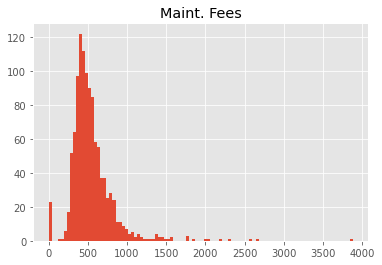

In [49]:
Apt_dataset[Apt_dataset['Taxes Included']==1].hist('Maint. Fees',bins=100)

In [50]:
Apt_dataset=Apt_dataset.drop('Taxes Included',axis=1)

array([[<AxesSubplot:title={'center':'Taxes'}>]], dtype=object)

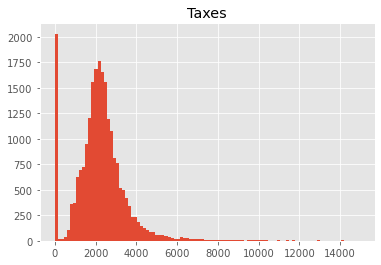

In [51]:
Apt_dataset[Apt_dataset['Taxes']<15000].hist('Taxes',bins=100)

In [52]:
Apt_dataset=Apt_dataset[Apt_dataset['Taxes']>100]
Apt_dataset=Apt_dataset[Apt_dataset['Taxes']<10000]

In [53]:
Apt_dataset[['Taxes','Sold Price']].corr(method ='pearson')

,Taxes,Sold Price
Taxes,1.000000,0.877257
Sold Price,0.877257,1.000000


In [54]:
Apt_dataset['Taxes'].describe()

count    20810.000000
mean      2438.114481
std       1083.597162
min        130.000000
25%       1800.000000
50%       2264.995000
75%       2840.057500
max       9968.730000
Name: Taxes, dtype: float64

array([[<AxesSubplot:title={'center':'Taxes'}>]], dtype=object)

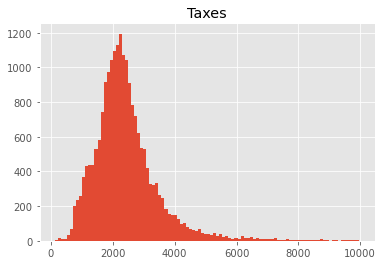

In [55]:
Apt_dataset.hist('Taxes',bins=100)

In [56]:
Apt_dataset['Maint. Fees'].describe()

count    20810.000000
mean       564.542864
std        241.767761
min          0.000000
25%        411.000000
50%        516.000000
75%        661.000000
max       4800.000000
Name: Maint. Fees, dtype: float64

In [57]:
Apt_dataset[Apt_dataset['Maint. Fees']!=0][['Maint. Fees','Sold Price']].corr(method ='pearson')

,Maint. Fees,Sold Price
Maint. Fees,1.000000,0.508387
Sold Price,0.508387,1.000000


array([[<AxesSubplot:title={'center':'Maint. Fees'}>]], dtype=object)

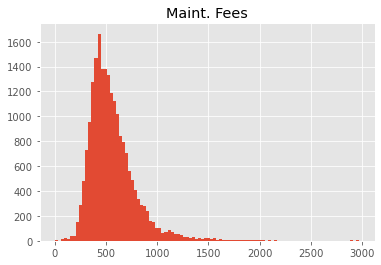

In [58]:
Apt_dataset[Apt_dataset['Maint. Fees']<3000].hist('Maint. Fees',bins=100)

In [59]:
Apt_dataset=Apt_dataset[(Apt_dataset['Maint. Fees']>200)|(Apt_dataset["Condo Apt"]!=0)]
Apt_dataset=Apt_dataset[Apt_dataset['Maint. Fees']>30]
Apt_dataset=Apt_dataset[Apt_dataset['Maint. Fees']<2000]

In [60]:
Apt_dataset['Maint. Fees'].describe()

count    20649.000000
mean       563.040293
std        222.589300
min        162.000000
25%        413.000000
50%        517.000000
75%        661.000000
max       1995.000000
Name: Maint. Fees, dtype: float64

array([[<AxesSubplot:title={'center':'Maint. Fees'}>]], dtype=object)

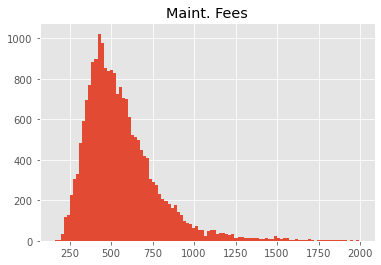

In [61]:
Apt_dataset.hist('Maint. Fees',bins=100)

In [62]:
Apt_dataset[['Maint. Fees','Sold Price']].corr(method ='pearson')

,Maint. Fees,Sold Price
Maint. Fees,1.000000,0.489344
Sold Price,0.489344,1.000000


In [63]:
Apt_dataset[['Maint. Fees','Taxes']].corr(method ='pearson')

,Maint. Fees,Taxes
Maint. Fees,1.000000,0.441111
Taxes,0.441111,1.000000


In [64]:
Apt_dataset['AC Type'].value_counts()

Central Air    19010
None             898
Window Unit      350
Wall Unit        269
Other            122
Name: AC Type, dtype: int64

In [65]:
Apt_dataset['AC Type']=Apt_dataset['AC Type'].replace("Other",0)
Apt_dataset['AC Type']=Apt_dataset['AC Type'].replace("Wall Unit",0)
Apt_dataset['AC Type']=Apt_dataset['AC Type'].replace("Window Unit",0)
Apt_dataset['AC Type']=Apt_dataset['AC Type'].replace("None",0)
Apt_dataset['AC Type']=Apt_dataset['AC Type'].replace("Central Air",1)
Apt_dataset['AC Type'].value_counts()

1    19010
0     1639
Name: AC Type, dtype: int64

In [66]:
Apt_dataset['Heat Type'].value_counts()

Forced Air    17698
Heat Pump      1322
Baseboard       680
Water           428
Radiant         337
Other           115
Fan Coil         69
Name: Heat Type, dtype: int64

In [67]:
Apt_dataset['Heat Type']=Apt_dataset['Heat Type'].replace("Fan Coil",0)
Apt_dataset['Heat Type']=Apt_dataset['Heat Type'].replace("Other",0)
Apt_dataset['Heat Type']=Apt_dataset['Heat Type'].replace("Heat Pump",0)
Apt_dataset['Heat Type']=Apt_dataset['Heat Type'].replace("Radiant",0)
Apt_dataset['Heat Type']=Apt_dataset['Heat Type'].replace("Water",0)
Apt_dataset['Heat Type']=Apt_dataset['Heat Type'].replace("Baseboard",0)
Apt_dataset['Heat Type']=Apt_dataset['Heat Type'].replace("Forced Air",1)
Apt_dataset['Heat Type'].value_counts()

1    17698
0     2951
Name: Heat Type, dtype: int64

In [68]:
Apt_dataset['Locker']=Apt_dataset['Locker'].replace("Exclusive",1)
Apt_dataset['Locker']=Apt_dataset['Locker'].replace("Other",0)
Apt_dataset['Locker']=Apt_dataset['Locker'].replace("Ensuite",1)
Apt_dataset['Locker']=Apt_dataset['Locker'].replace("Ensuite+Owned",1)
Apt_dataset['Locker']=Apt_dataset['Locker'].replace("Ensuite+Exclusive",1)
Apt_dataset['Locker']=Apt_dataset['Locker'].replace("Ensuite+Common",1)
Apt_dataset['Locker']=Apt_dataset['Locker'].replace("Common",1)
Apt_dataset['Locker']=Apt_dataset['Locker'].replace("None",0)
Apt_dataset['Locker']=Apt_dataset['Locker'].replace("Owned",1)
Apt_dataset['Locker'].value_counts()

1    14140
0     6509
Name: Locker, dtype: int64

In [69]:
#Apt_dataset['Balcony'].value_counts()

In [70]:
Apt_dataset['Balcony']=Apt_dataset['Balcony'].replace("None",0)
Apt_dataset['Balcony']=Apt_dataset['Balcony'].replace("Open",1)
Apt_dataset['Balcony']=Apt_dataset['Balcony'].replace("Terr",1)
Apt_dataset['Balcony']=Apt_dataset['Balcony'].replace("Jlte",1)
Apt_dataset['Balcony']=Apt_dataset['Balcony'].replace("Encl",1)
Apt_dataset['Balcony'].value_counts()

1    16966
0     3683
Name: Balcony, dtype: int64

In [71]:
Apt_dataset['Pets Permitted'].value_counts()

Restrict    19223
N            1426
Name: Pets Permitted, dtype: int64

In [72]:
Apt_dataset['Pets Permitted']=Apt_dataset['Pets Permitted'].replace("Restrict",1)
Apt_dataset['Pets Permitted']=Apt_dataset['Pets Permitted'].replace("N",0)
Apt_dataset['Pets Permitted'].value_counts()

1    19223
0     1426
Name: Pets Permitted, dtype: int64

In [73]:
Apt_dataset=Apt_dataset.drop('Pets Permitted',axis=1) #low varience

In [74]:
Apt_dataset['Heat Source'].value_counts()

Gas          18621
Electric      1738
Other          268
Grnd Srce       16
Oil              5
Wood             1
Name: Heat Source, dtype: int64

In [75]:
Apt_dataset['Heat Source']=Apt_dataset['Heat Source'].replace("Gas",1)
Apt_dataset['Heat Source']=Apt_dataset['Heat Source'].replace("Grnd Srce",0)
Apt_dataset['Heat Source']=Apt_dataset['Heat Source'].replace("Oil",0)
Apt_dataset['Heat Source']=Apt_dataset['Heat Source'].replace("Wood",0)
Apt_dataset['Heat Source']=Apt_dataset['Heat Source'].replace("Other",0)
Apt_dataset['Heat Source']=Apt_dataset['Heat Source'].replace("Propane",0)
Apt_dataset['Heat Source']=Apt_dataset['Heat Source'].replace("Electric",0)
Apt_dataset['Heat Source'].value_counts()

1    18621
0     2028
Name: Heat Source, dtype: int64

In [76]:
Apt_dataset['Total Rooms'].value_counts()

5.0     8936
4.0     5143
6.0     4169
7.0     1188
3.0      601
8.0      313
2.0      115
1.0       96
9.0       64
10.0      10
11.0       4
0.0        4
12.0       4
66.0       2
Name: Total Rooms, dtype: int64

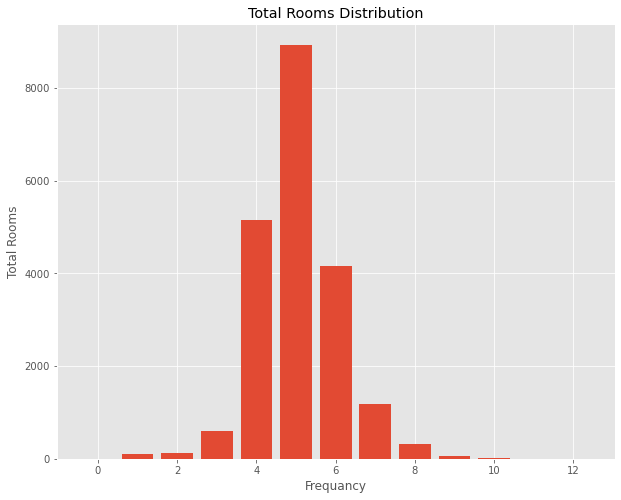

In [77]:
fig = plt.figure(figsize =(10,8 ))
ss=Apt_dataset[Apt_dataset['Total Rooms']<30]['Total Rooms'].value_counts().sort_index()
plt.bar(list(ss.keys()),list(ss.values))
plt.title('Total Rooms Distribution')
plt.ylabel('Total Rooms')
plt.xlabel('Frequancy')
plt.show()

In [78]:
Apt_dataset=Apt_dataset.drop('Total Rooms',axis=1)

In [79]:
Apt_dataset['Sale to List %'].value_counts()

99.0     3173
100.0    3065
98.0     2924
97.0     1937
96.0     1118
         ... 
178.0       1
74.0        1
68.0        1
152.0       1
78.0        1
Name: Sale to List %, Length: 84, dtype: int64

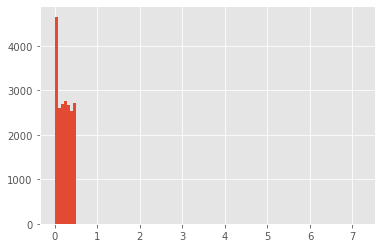

In [80]:
err=[abs(100*(float(b)/a)-c) for a,b,c in zip(Apt_dataset["List Price"],Apt_dataset["Sold Price"],Apt_dataset['Sale to List %'])]
plt.hist(err,bins=100)
plt.show()

In [81]:
print(sum([x>1 for x in err]))
Apt_dataset["err"]=err

3


In [82]:
Apt_dataset=Apt_dataset[Apt_dataset["err"]<1]
Apt_dataset=Apt_dataset.drop("err",axis=1)

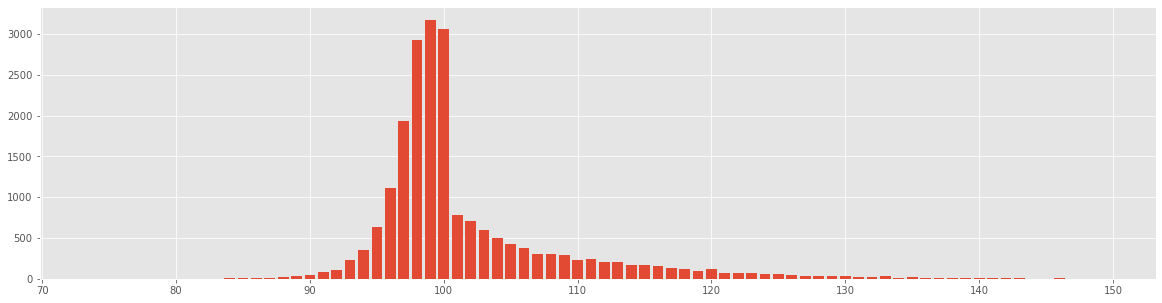

In [83]:
fig = plt.figure(figsize =(20,5))
ss=Apt_dataset['Sale to List %'].value_counts().sort_index()
ss=ss[ss.keys()<150]
ss=ss[ss.keys()>70]
plt.bar(list(ss.keys()),list(ss.values))
plt.show()

In [84]:
Apt_dataset=Apt_dataset[Apt_dataset["Sale to List %"]>70]

In [85]:
SS=Apt_dataset["Ward"].value_counts()
SS[SS.values < 50].keys()

Index(['E06', 'W07'], dtype='object')

In [86]:
Apt_dataset=Apt_dataset[~(Apt_dataset["Ward"].isin(list(SS[SS.values < 50].keys())))]

In [87]:
for name in set(Apt_dataset["Ward"]):
    Apt_dataset[name]=(Apt_dataset["Ward"]==name).astype(int)
    
neighbourhoods=[set(Apt_dataset["Ward"])]
Apt_dataset=Apt_dataset.drop("Ward",axis=1)  

In [88]:
#Apt_dataset['green_new'].describe()

In [89]:
#Apt_dataset.boxplot(['green_new'])

In [90]:
#Apt_dataset.hist('green_new',bins=21,legend=True)

In [91]:
len(Apt_dataset.columns)

89

In [92]:
(Apt_dataset.describe().T)[((Apt_dataset.describe().T)['mean']<0.05)]

,count,mean,std,min,25%,50%,75%,max
Bike Storage,20575.0,0.016185,0.126188,0.0,0.0,0.0,0.0,1.0
Bus Ctr (Wifi Bldg),20575.0,0.011762,0.107815,0.0,0.0,0.0,0.0,1.0
Car Wash,20575.0,0.025468,0.157545,0.0,0.0,0.0,0.0,1.0
Lap Pool,20575.0,0.008991,0.094399,0.0,0.0,0.0,0.0,1.0
Satellite Dish,20575.0,0.000389,0.019715,0.0,0.0,0.0,0.0,1.0
Squash/Racquet Court,20575.0,0.038056,0.191336,0.0,0.0,0.0,0.0,1.0
Other Property,20575.0,0.024399,0.154287,0.0,0.0,0.0,0.0,1.0
E11,20575.0,0.017060,0.129496,0.0,0.0,0.0,0.0,1.0
E04,20575.0,0.019684,0.138916,0.0,0.0,0.0,0.0,1.0
C02,20575.0,0.017643,0.131652,0.0,0.0,0.0,0.0,1.0


In [93]:
(Apt_dataset.describe().T)[((Apt_dataset.describe().T)['mean']<1)&((Apt_dataset.describe().T)['mean']>0.95)]

,count,mean,std,min,25%,50%,75%,max
Common Elements Included,20575.0,0.988919,0.104686,0.0,1.0,1.0,1.0,1.0
Water Included,20575.0,0.950960,0.215957,0.0,1.0,1.0,1.0,1.0
Ensuite Laundry,20575.0,0.954751,0.207855,0.0,1.0,1.0,1.0,1.0


In [94]:
Apt_dataset=Apt_dataset.drop(['Common Elements Included','Water Included','Satellite Dish','Ensuite Laundry'],axis=1)

In [95]:
Apt_dataset['Sold Price'].describe()

count    2.057500e+04
mean     4.847100e+05
std      2.220423e+05
min      3.078000e+04
25%      3.500000e+05
50%      4.400000e+05
75%      5.600000e+05
max      3.410000e+06
Name: Sold Price, dtype: float64

In [96]:
Apt_dataset=Apt_dataset[Apt_dataset['Sold Price']<1525000]
Apt_dataset=Apt_dataset[Apt_dataset['Sold Price']>125000]

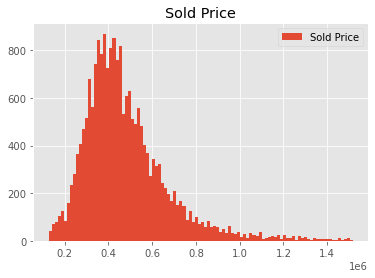

In [97]:
Apt_dataset.hist("Sold Price",bins=100)
plt.legend(labels=['Sold Price'])

In [98]:
Apt_dataset["log price"]=np.log(Apt_dataset['Sold Price'].tolist())
print(Apt_dataset["log price"].describe())

count    20356.000000
mean        13.005906
std          0.379822
min         11.744037
25%         12.765688
50%         12.994530
75%         13.235692
max         14.232904
Name: log price, dtype: float64


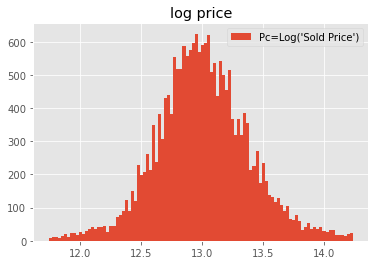

In [99]:
Apt_dataset.hist("log price",bins=100)
plt.legend(labels=["Pc=Log('Sold Price')"])

In [100]:
# creat classes for sold price labl
#df1['score_floor'] = df1['Score'].apply(np.floor)
Apt_dataset["price class"]=round((Apt_dataset['Sold Price']-150000)/50000).astype(int)
Apt_dataset[["price class"]]

,price class
3667,27
3669,27
3690,27
3707,27
3710,27
...,...
39789,0
39790,0
39793,0
39807,7


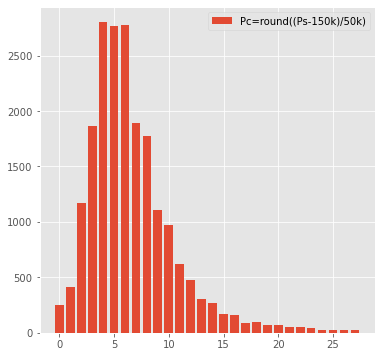

In [101]:
#House_dataset["price class"].value_counts().sort_index()
fig = plt.figure(figsize =(6,6))
ss=Apt_dataset['price class'].value_counts().sort_index()
plt.bar(list(ss.keys()),list(ss.values))
plt.legend(labels=["Pc=round((Ps-150k)/50k)"])

In [102]:
print(Apt_dataset["List Price"].describe())

count    2.035600e+04
mean     4.711816e+05
std      1.926249e+05
min      9.990000e+04
25%      3.490000e+05
50%      4.299000e+05
75%      5.490000e+05
max      1.599900e+06
Name: List Price, dtype: float64


In [103]:
print(Apt_dataset['Days on Market'].describe())

count    20356.000000
mean        19.031981
std         21.390035
min          0.000000
25%          6.000000
50%         12.000000
75%         24.000000
max        312.000000
Name: Days on Market, dtype: float64


In [104]:
print(Apt_dataset['Date'].describe())

count    20356.000000
mean        11.522598
std          6.692475
min          0.000000
25%          6.000000
50%         11.000000
75%         17.000000
max         24.000000
Name: Date, dtype: float64


In [105]:
Apt_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20356 entries, 3667 to 39846
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bedrooms AG           20356 non-null  float64
 1   Bedrooms BG           20356 non-null  float64
 2   Washrooms             20356 non-null  int64  
 3   Family Room           20356 non-null  int64  
 4   Square Feet           20356 non-null  int64  
 5   Taxes                 20356 non-null  float64
 6   Maint. Fees           20356 non-null  float64
 7   AC Type               20356 non-null  int64  
 8   Heat Type             20356 non-null  int64  
 9   Heat included         20356 non-null  float64
 10  Hydro Included        20356 non-null  float64
 11  Parking Included      20356 non-null  float64
 12  Locker                20356 non-null  int64  
 13  Balcony               20356 non-null  int64  
 14  Heat Source           20356 non-null  int64  
 15  green_new       

In [106]:
corr=Apt_dataset.corr(method ='pearson')
#corr
corr[abs(corr["price class"])>0.5][["log price"]]


,log price
Taxes,0.835833
Sold Price,0.956616
List Price,0.935218
log price,1.000000
price class,0.953836


In [107]:
Apt_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20356 entries, 3667 to 39846
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bedrooms AG           20356 non-null  float64
 1   Bedrooms BG           20356 non-null  float64
 2   Washrooms             20356 non-null  int64  
 3   Family Room           20356 non-null  int64  
 4   Square Feet           20356 non-null  int64  
 5   Taxes                 20356 non-null  float64
 6   Maint. Fees           20356 non-null  float64
 7   AC Type               20356 non-null  int64  
 8   Heat Type             20356 non-null  int64  
 9   Heat included         20356 non-null  float64
 10  Hydro Included        20356 non-null  float64
 11  Parking Included      20356 non-null  float64
 12  Locker                20356 non-null  int64  
 13  Balcony               20356 non-null  int64  
 14  Heat Source           20356 non-null  int64  
 15  green_new       

In [108]:
len(Apt_dataset.columns)

87

In [112]:
Apt_dataset.to_csv("Apt_dataset.csv",index=False)
pd.read_csv("Apt_dataset.csv")

,Bedrooms AG,Bedrooms BG,Washrooms,Family Room,Square Feet,Taxes,Maint. Fees,AC Type,Heat Type,Heat included,...,C08,E10,E05,E01,W04,W10,C10,C01,log price,price class
0,3.0,0.0,2,0,1900,5577.69,1855.0,1,1,1.0,...,0,0,0,0,0,0,0,0,14.232904,27
1,2.0,1.0,3,0,1700,4400.38,1622.0,1,1,1.0,...,0,0,0,0,0,0,0,1,14.232904,27
2,2.0,1.0,2,0,1500,6721.50,1049.0,1,1,1.0,...,0,0,0,0,0,0,0,1,14.227620,27
3,2.0,1.0,2,0,1700,9721.06,1435.0,1,1,1.0,...,0,0,0,0,0,0,0,1,14.224303,27
4,2.0,1.0,2,1,1700,6294.96,1750.0,1,0,0.0,...,0,0,0,0,0,0,0,0,14.224303,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20351,2.0,0.0,1,0,850,653.58,686.0,1,0,1.0,...,0,0,0,0,0,0,0,0,11.751942,0
20352,3.0,0.0,2,0,1300,476.39,583.0,1,1,1.0,...,0,0,0,0,0,1,0,0,11.751942,0
20353,1.0,0.0,1,0,750,703.84,433.0,0,0,1.0,...,0,0,0,0,0,0,0,0,11.744037,0
20354,2.0,0.0,2,0,950,2441.48,675.0,1,1,1.0,...,0,0,0,0,0,0,0,0,13.151922,7


In [109]:
#Heat Maps
#fig=plt.gcf()
#fig.set_size_inches(10,7)
#fig=sns.heatmap(corr[corr>0.2],annot=True,cmap='cubehelix',linewidths=1,linecolor='k',square=True,mask=False, vmin=-1, vmax=1,cbar_kws={"orientation": "vertical"},cbar=True)